In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime as dt
import plotly.express as px

In [ ]:
project_id = 'tc-da-1'
from google.cloud import bigquery

In [ ]:
client = bigquery.Client(project=project_id)
dataset_ref = client.dataset("turing_data_analytics", project = project_id)
dataset = client.get_dataset(dataset_ref)

In [ ]:
tables = list(client.list_tables(dataset))
for table in tables:
  print(table.table_id)

adsense_monthly
raw_events
rfm
rfm_quantiles
rfm_score
rfm_value
stackoverflow_posts
subscriptions


In [ ]:
#rfm table is the third in list
print(tables[2])
print(tables[2].table_id)

rfm


In [ ]:
sql_table_id = tables[2]
sql_table_id

In [ ]:
df = client.list_rows(sql_table_id).to_dataframe()

In [ ]:
#Dataframe has been created:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536414,22139,None,56,2010-12-01 11:52:00+00:00,0.00,<NA>,United Kingdom
1,536544,22081,RIBBON REEL FLORA + FAUNA,1,2010-12-01 14:32:00+00:00,3.36,<NA>,United Kingdom
2,536544,22100,SKULLS SQUARE TISSUE BOX,1,2010-12-01 14:32:00+00:00,2.51,<NA>,United Kingdom
3,536544,22114,HOT WATER BOTTLE TEA AND SYMPATHY,3,2010-12-01 14:32:00+00:00,8.47,<NA>,United Kingdom
4,536544,22196,SMALL HEART MEASURING SPOONS,2,2010-12-01 14:32:00+00:00,1.66,<NA>,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype              
---  ------       --------------   -----              
 0   InvoiceNo    541909 non-null  object             
 1   StockCode    541909 non-null  object             
 2   Description  540455 non-null  object             
 3   Quantity     541909 non-null  Int64              
 4   InvoiceDate  541909 non-null  datetime64[ns, UTC]
 5   UnitPrice    541909 non-null  float64            
 6   CustomerID   406829 non-null  Int64              
 7   Country      541909 non-null  object             
dtypes: Int64(2), datetime64[ns, UTC](1), float64(1), object(4)
memory usage: 34.1+ MB


In [ ]:
#Removing timezone from InvoiceDate
df['InvoiceDate'] = df['InvoiceDate'].dt.tz_localize(None)

In [ ]:
#Excluding Negative Values in Quantity
df = df[df['Quantity'] >= 0]

In [ ]:
#Excluding Negative Values in UnitPrice
df = df[df['UnitPrice'] >= 0]

In [ ]:
#Dropping Duplicated Values
df = df.drop_duplicates()

In [ ]:
#Creating ‘TotalPrice’ Column
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

In [ ]:
#Searching for the latest InvoiceDate
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [ ]:
#Analysis is on 2011-12-10 (latest InvoiceDate date 2011-12-09)
now = dt.datetime(2011,12,10)

In [ ]:
#Calculating recency, frequency and monetary
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda date: (now - date.max()).days,
                                   'InvoiceNo': lambda num: len(num),
                                   'TotalPrice': lambda price: price.sum()})
rfm.columns
#Change the name of columns
rfm.columns = ['recency', 'frequency', 'monetary']

In [ ]:
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346,325,1,77183.6
12347,2,182,4310.0
12348,75,31,1797.24
12349,18,73,1757.55
12350,310,17,334.4


In [ ]:
#Calculating RFM scores
rfm['R'] = pd.qcut(rfm['recency'], 4, labels=[4,3,2,1])
rfm['F'] = pd.qcut(rfm['frequency'], 4, labels=[1,2,3,4])
rfm['M'] = pd.qcut(rfm['monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = rfm['R'].astype(str) +rfm['F'].astype(str) + rfm['M'].astype(str)
rfm.head()

,recency,frequency,monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12346,325,1,77183.6,1,1,4,114
12347,2,182,4310.0,4,4,4,444
12348,75,31,1797.24,2,2,4,224
12349,18,73,1757.55,3,3,4,334
12350,310,17,334.4,1,1,2,112


In [ ]:
#Customer segmentation by recency, frequency and monetary score
def segment_df(rfm):

    loyal_customers = ['342', '343', '344', '433', '434','443', '234']
    potentially_loyalist_customers = ['332', '333', '341', '412', '413',
                                      '414','431', '432', '441', '442',
                                      '421', '422', '423', '424', '324']
    needing_attention_customers = ['323', '322', '321', '314', '241',
                                   '233', '232', '231', '214', '213', '212']
    promising_customers = ['331','313','312','311']
    risk_customers = ['211', '221', '222', '223', '224', '121', '122',
                      '123', '124', '142', '133', '132', '131', '114',
                      '113', '112']
    cant_loose_them_customers = ['244', '243', '242', '144', '143', '134']

    if (rfm['RFM_Score'] == '444'
        or rfm['RFM_Score'] == '334'):
        return 'Best Customers'

    if (rfm['RFM_Score'] in loyal_customers):
        return 'Loyal Customers'

    if (rfm['RFM_Score'] in potentially_loyalist_customers):
        return 'Potential Loyalist Customers'

    if (rfm['RFM_Score'] == '411'):
        return 'Recent Customers'

    if (rfm['RFM_Score'] in promising_customers):
        return 'Promising Customers'

    if (rfm['RFM_Score'] in needing_attention_customers):
        return 'Needing Attention Customers'

    if (rfm['RFM_Score'] in risk_customers):
        return 'At Risk Customers'

    if (rfm['RFM_Score'] in cant_loose_them_customers):
        return 'Cant Lose Them Customers'

    if (rfm['RFM_Score'] == '111'):
        return 'Lost Customers'

rfm['Segment'] = rfm.apply(segment_df, axis = 1)

In [ ]:
rfm.head()

,recency,frequency,monetary,R,F,M,RFM_Score,Segment
CustomerID,,,,,,,,
12346,325,1,77183.6,1,1,4,114,At Risk Customers
12347,2,182,4310.0,4,4,4,444,Best Customers
12348,75,31,1797.24,2,2,4,224,At Risk Customers
12349,18,73,1757.55,3,3,4,334,Best Customers
12350,310,17,334.4,1,1,2,112,At Risk Customers



**ANALYSIS OVERVIEW**

In [ ]:
#Counting number of customers
customers = len(pd.unique(df['CustomerID']))

print('Number Of Customers:', customers)

Number Of Customers: 4340


In [ ]:
#Calculating total revenue
revenue = df['TotalPrice'].sum()

print('Total Revenue:', revenue)

Total Revenue: 10642110.804


In [ ]:
#Calculating revenue per customer
revenue_per_customer = revenue / customers

print('Revenue Per Customer:', revenue_per_customer)

Revenue Per Customer: 2452.09926359447


In [ ]:
#Converting InvoiceDate to a month format
df['OrderMonth'] = df['InvoiceDate'].dt.month

In [ ]:
#Monthly sales chart

#Converting InvoiceDate to a month format
df['OrderMonth'] = df['InvoiceDate'].dt.month

#Grouping and calculating revenue by month
sales_by_month = df.groupby('OrderMonth')['TotalPrice'].sum().reset_index()

#Drawing line chart
fig = px.line(sales_by_month,
              x = 'OrderMonth',
              y = 'TotalPrice',
              title = 'Monthly Sales')
fig.update_layout(xaxis_title = 'Month', yaxis_title = 'Revenue')
fig.show()

Insight:

*   In the beginning of companies life revenue per month was quite, but since the 8th month it started to increase. Company is going into right direction.



In [ ]:
#Bar chart for countries

#Grouping and calculating revenue by country, sorting decending and taking only 10 top countries
sales_by_country = df.groupby('Country').agg({'TotalPrice': 'sum'}).sort_values(by = 'TotalPrice', ascending = False).head(10)
sales_by_country.reset_index(inplace = True)
sales_by_country.columns = ['Country', 'TotalPrice']

#Drawing bar chart
fig = px.bar(sales_by_country,
             x = 'Country',
             y = 'TotalPrice',
             title = 'Top Ten Countries By Revenue')
fig.update_layout(xaxis_title = '', yaxis_title = 'Revenue')
fig.show()

Insight:

*   Country from which comes the biggest is United Kingdom (around 9,0M dollars)



In [ ]:
#Number of customers in RFM segments
rfm.Segment.value_counts()

At Risk Customers               1155
Loyal Customers                  694
Needing Attention Customers      600
Potential Loyalist Customers     528
Best Customers                   502
Lost Customers                   381
Cant Lose Them Customers         214
Promising Customers              199
Recent Customers                  66
Name: Segment, dtype: int64

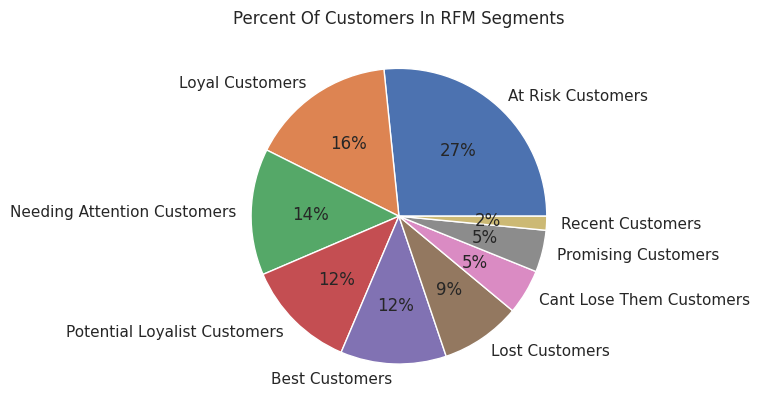

In [ ]:
#Drawing pie chart for the number of customers

plt.title('Percent Of Customers In RFM Segments')
plt.pie(rfm.Segment.value_counts(),
        labels = rfm.Segment.value_counts().index,
        autopct = '%.0f%%')
plt.show()

In [ ]:
#Bar chart describing monetary

#Grouping by segment and calculating revenue
monetary = rfm.groupby('Segment')['monetary'].sum().reset_index()

#Drawing bar chart
fig = px.bar(monetary,
             x = 'monetary',
             y = 'Segment',
             title = 'Monetary In RFM Segments')
fig.update_layout(barmode = 'stack', yaxis = {'categoryorder':'total ascending'})
fig.update_layout(xaxis_title = '', yaxis_title = '')
fig.show()

Insight:

*   Majority of revenue comes from the customers which are in the Best Customers and Loyal Customers Segments



In [ ]:
#Scatter chart describing recency and frequency

#Grouping by segment and calculating average of revenue and frequency
segments = rfm.groupby('Segment').agg({'recency': 'mean', 'frequency': 'mean'}).reset_index()

#Drawing scatter chart
fig = px.scatter(segments,
                 x = 'recency',
                 y = 'frequency',
                 color = 'Segment',
                 hover_name = 'Segment',
                 title = 'Customers Distribution By Recency And Frequency')
fig.update_layout(xaxis_title = 'Recency', yaxis_title = 'Frequency')
fig.show()